In [ ]:
# Full Hybrid Intent Classification Pipeline (PyTorch)
# Steps 1 to 7: Preprocessing, Feature Extraction, Modeling, Training

import torch  # Go to readme for instructions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import Dataset, DataLoader
import spacy
import pandas as pd
import numpy as np
import random
import os

# ------------------------------
# Step 1: Data Loading & Feature Extraction
# ------------------------------

# Load data
df = pd.read_csv("random_augmented_balanced_dataset.csv")
df.dropna(inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['intent'])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=400)
tfidf_features = tfidf_vectorizer.fit_transform(df['text']).toarray()

nlp = spacy.load("en_core_web_md")
pos_tags = []
for doc in nlp.pipe(df['text'].tolist(), batch_size=64):
    counts = doc.count_by(spacy.attrs.POS)
    vec = np.array([counts.get(i, 0) for i in range(len(nlp.vocab))])[:100]  # fixed POS length
    pos_tags.append(vec)
pos_tags = np.array(pos_tags)

# Concatenate shallow features
shallow_features = np.concatenate([tfidf_features, pos_tags], axis=1)
shallow_dim = shallow_features.shape[1]

# Tokenizer for BERT
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Split
txt_train, txt_val, shallow_train, shallow_val, y_train, y_val = train_test_split(
    df['text'], shallow_features, df['label'], test_size=0.2, random_state=42)

# ------------------------------
# Step 2: Dataset Class
# ------------------------------
class IntentDataset(Dataset):
    def __init__(self, texts, shallow_feats, labels, tokenizer, max_len=192):
        self.texts = texts.tolist()
        self.shallow_feats = shallow_feats
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'shallow_feats': torch.tensor(self.shallow_feats[idx], dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# ------------------------------
# Step 3: BERT + Shallow Features
# ------------------------------
class HybridIntentClassifier(nn.Module):
    def __init__(self, shallow_dim, hidden_dim, num_classes, dropout):
        super(HybridIntentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1", trust_remote_code=True, use_safetensors=True)

        self.shallow_proj = nn.Linear(shallow_dim, hidden_dim)
        self.deep_proj = nn.Linear(768, hidden_dim)

        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, shallow_feats, deep_input_ids, deep_attention_mask):
        bert_output = self.bert(input_ids=deep_input_ids, attention_mask=deep_attention_mask)
        deep_feats = bert_output.last_hidden_state[:, 0, :]  # CLS

        proj_shallow = self.shallow_proj(shallow_feats).unsqueeze(1)
        proj_deep = self.deep_proj(deep_feats).unsqueeze(1)

        attn_output, _ = self.cross_attention(query=proj_shallow, key=proj_deep, value=proj_deep)

        fused = attn_output.squeeze(1)
        return self.classifier(fused)

# ------------------------------
# Step 4: DataLoader
# ------------------------------
train_dataset = IntentDataset(txt_train, shallow_train, y_train, tokenizer)
val_dataset = IntentDataset(txt_val, shallow_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# ------------------------------
# Step 5-6: Training Prep
# ------------------------------
model = HybridIntentClassifier(shallow_dim=shallow_dim, hidden_dim=512, num_classes=10, dropout=0.3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.05)
total_training_steps = len(train_loader) * 10
warmup_steps = int(0.05 * total_training_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_training_steps)

# ------------------------------
# Step 7: Training Loop
# ------------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=3, device="cuda"):
    model.to(device)
    best_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            shallow_feats = batch['shallow_feats'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(shallow_feats, input_ids, attn_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        preds, targets = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attn_mask = batch['attention_mask'].to(device)
                shallow_feats = batch['shallow_feats'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(shallow_feats, input_ids, attn_mask)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                pred_labels = torch.argmax(outputs, dim=1)
                preds.extend(pred_labels.cpu().numpy())
                targets.extend(labels.cpu().numpy())

        val_loss = np.mean(val_losses)
        print(f"Epoch {epoch+1} | Train Loss: {np.mean(train_losses):.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy_score(targets, preds):.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    print("\nFinal Evaluation Report:")
    print(classification_report(targets, preds, digits=4))

# ------------------------------
# Call Training
# ------------------------------
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)


Epoch 1 | Train Loss: 1.7756 | Val Loss: 1.3265 | Val Acc: 0.5051
Epoch 2 | Train Loss: 1.1822 | Val Loss: 1.0422 | Val Acc: 0.6176
Epoch 3 | Train Loss: 0.8451 | Val Loss: 0.9751 | Val Acc: 0.6624
Epoch 4 | Train Loss: 0.6031 | Val Loss: 0.9149 | Val Acc: 0.7032
Epoch 5 | Train Loss: 0.4264 | Val Loss: 0.9487 | Val Acc: 0.7201
Epoch 6 | Train Loss: 0.2804 | Val Loss: 0.9770 | Val Acc: 0.7579
Epoch 7 | Train Loss: 0.1890 | Val Loss: 1.0663 | Val Acc: 0.7791
Early stopping triggered.

Final Evaluation Report:
              precision    recall  f1-score   support

           0     0.8614    0.9125    0.8862       320
           1     0.8361    0.8388    0.8374       304
           2     0.6713    0.8408    0.7465       289
           3     0.9003    0.9030    0.9017       330
           4     0.7479    0.6098    0.6718       287
           5     0.8784    0.7568    0.8131       296
           6     0.7246    0.6310    0.6746       271
           7     0.5884    0.5344    0.5601       305


✅ Final Test Accuracy: 0.7791

📊 Classification Report:
                        precision    recall  f1-score   support

    applicable disease     0.8614    0.9125    0.8862       320
              ask more     0.8361    0.8388    0.8374       304
                 cause     0.6713    0.8408    0.7465       289
            definition     0.9003    0.9030    0.9017       330
disease manifestations     0.7479    0.6098    0.6718       287
                method     0.8784    0.7568    0.8131       296
              symptoms     0.7246    0.6310    0.6746       271
             treatment     0.5884    0.5344    0.5601       305
      treatment method     0.6480    0.7582    0.6988       306
                 usage     0.9308    0.9642    0.9472       307

              accuracy                         0.7791      3015
             macro avg     0.7787    0.7749    0.7737      3015
          weighted avg     0.7812    0.7791    0.7772      3015



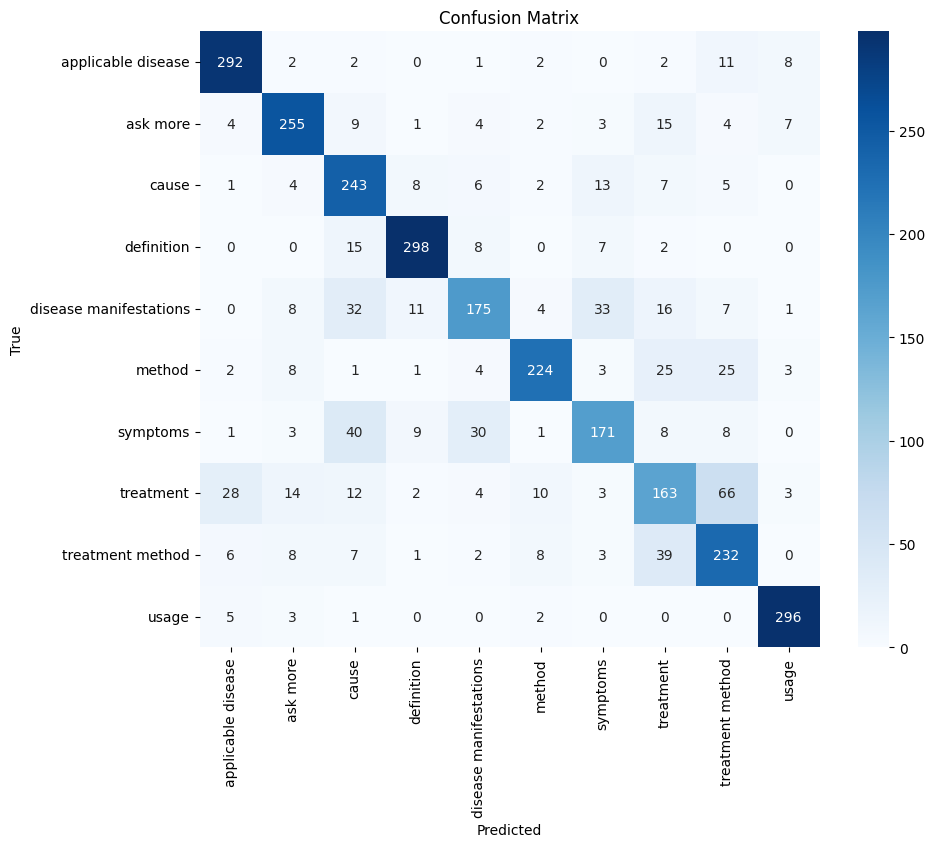

In [16]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_model(model, val_loader):
    model.eval()
    device = next(model.parameters()).device

    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            shallow_feats = batch['shallow_feats'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(shallow_feats, input_ids, attn_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Final Test Accuracy: {acc:.4f}\n")
    print("📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# 🔍 Final Evaluation
evaluate_model(model, val_loader)